<a href="https://colab.research.google.com/github/Souvik2biswas/Solar-cycle-prediction/blob/main/solar2cycle26_randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **25th Solar Cycle Prediction**

# Libraries

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


In [2]:
import optuna

optuna.__version__

'3.6.1'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset(1874-2023, 149Years)

In [5]:
data=pd.read_csv('/content/drive/MyDrive/Datasets/monthlySSA.csv', parse_dates=['DATE'])
data=data.set_index('DATE')
data

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2022-12-01,1326.4
2023-01-01,1846.2
2023-02-01,1278.5


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1788 entries, 1874-05-01 to 2023-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    1788 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


In [7]:
data.describe()

,Area
count,1788.000000
mean,812.125000
std,829.667186
min,0.000000
25%,149.250000
50%,561.400000
75%,1207.375000
max,4902.000000


# EDA

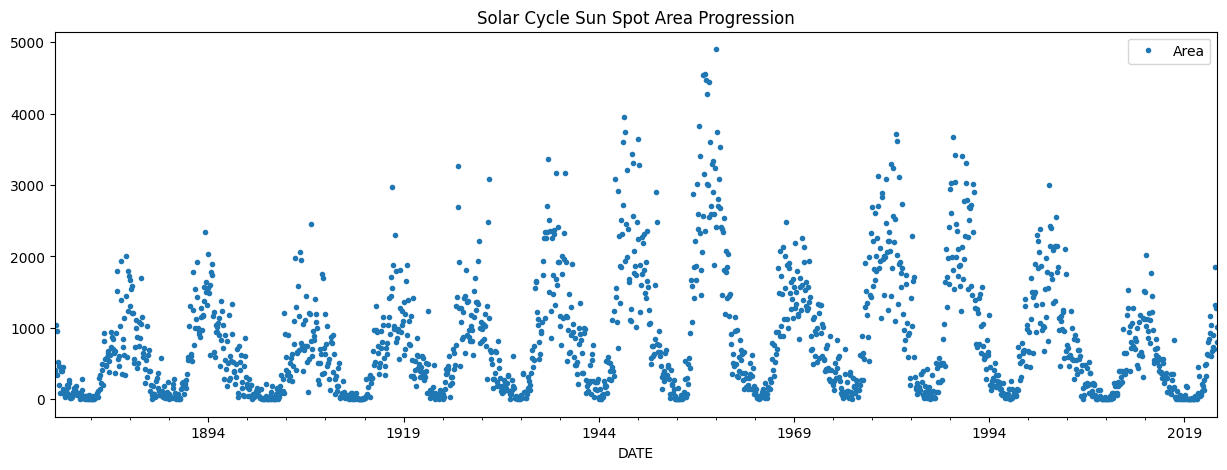

In [8]:
data.plot(style='.',
        figsize=(15, 5),
        title='Solar Cycle Sun Spot Area Progression')
plt.show()

In [9]:
data.query('Area == 0')

,Area
DATE,
1878-08-01,0.0
1879-02-01,0.0
1879-03-01,0.0
1889-11-01,0.0
1900-12-01,0.0
1901-04-01,0.0
1901-08-01,0.0
1901-12-01,0.0
1902-04-01,0.0


In [10]:
data.query('Area < 20')

,Area
DATE,
1876-04-01,15.8
1876-06-01,15.2
1877-07-01,4.2
1878-01-01,14.9
1878-02-01,18.1
...,...
2020-02-01,1.4
2020-03-01,1.4
2020-04-01,7.5


In [11]:
a = data.query('Area < 1000')
b = data.query('Area < 20')
c = data.query('Area > 1000')
plt.figure(figsize=(20,5), dpi=1000)
plt.scatter(x=a.index, y=a, marker='.', label='middle values')
plt.scatter(x=c.index, y=c, marker='.', label='higher values')
plt.scatter(x=b.index, y=b, marker='.', edgecolors='black', label='nearly zero values')
plt.legend(['upper values', 'middle values','zero values'])
plt.show()

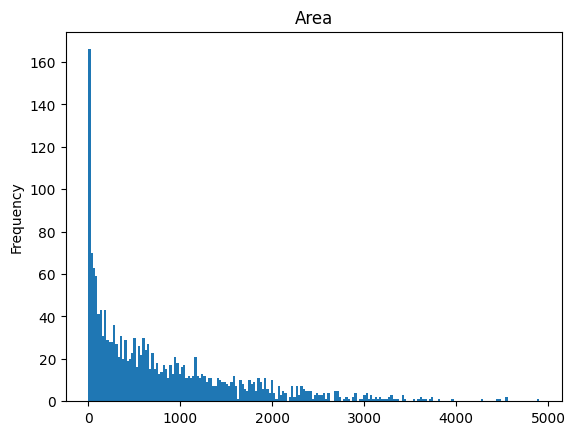

In [12]:
data['Area'].plot(kind='hist', bins=200, title='Area')
plt.gca().spines[['top', 'right',]].set_visible(True)

# Train-Test Split

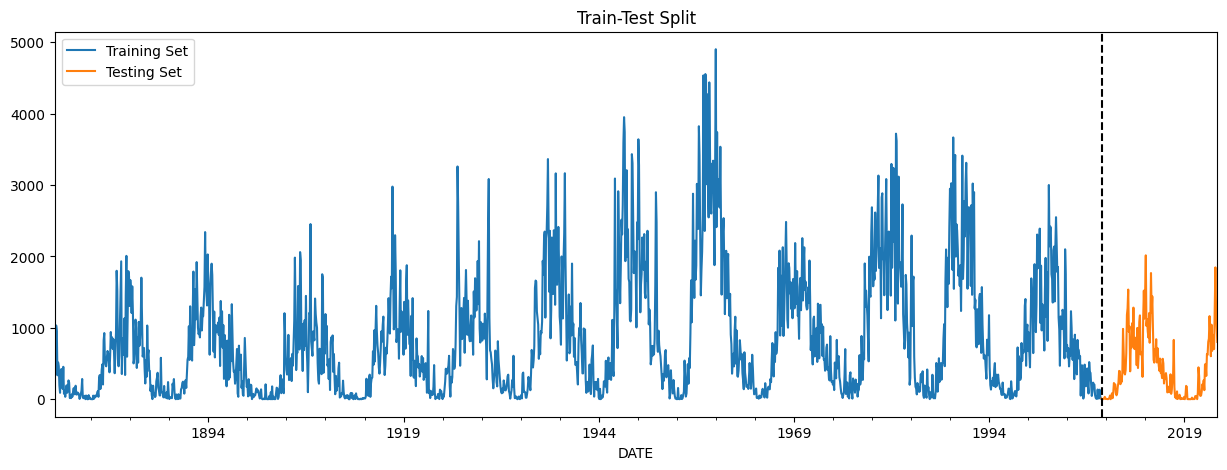

In [13]:
train_data = data.loc[data.index < '2008-06-01']
test_data = data.loc[data.index >= '2008-06-01']
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label='Training Set', title='Train-Test Split')
test_data.plot(ax=ax, label='Test Set')
ax.axvline('2008-06-01', color='black', ls='--')
ax.legend(['Training Set', 'Testing Set'])
plt.show()

In [14]:
train_data

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2008-01-01,12.2
2008-02-01,11.1
2008-03-01,133.2


In [15]:
def prepare_data(timeseries_data, n_steps):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        end_ix = i + n_steps
        if end_ix > len(timeseries_data)-1:
            break
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps=96
X_train, y_train = prepare_data(train_data['Area'], n_steps)
X_test, y_test = prepare_data(test_data['Area'], n_steps)

In [16]:
X_train.shape

(1513, 96)

In [17]:
X_test.shape

(83, 96)

In [18]:
X_train

array([[ 365.1,  415.2, 1033.5, ...,  673.1,  928.9, 1799.1],
       [ 415.2, 1033.5,  954.1, ...,  928.9, 1799.1, 1519.6],
       [1033.5,  954.1,  335.3, ..., 1799.1, 1519.6,  557.8],
       ...,
       [2306.4, 1834. , 2216.1, ...,  135.9,   12.2,   11.1],
       [1834. , 2216.1, 2055.2, ...,   12.2,   11.1,  133.2],
       [2216.1, 2055.2, 2389.5, ...,   11.1,  133.2,   40.6]])

In [22]:
ts_cv = TimeSeriesSplit(
    n_splits=8,
    gap=5,
    max_train_size=1800,
    test_size=180,
)

# 25th Cycle Prediction Model

In [23]:
def objective(trial):
      bootstrap = trial.suggest_categorical("bootstrap", [True, False])
      n_estimators = trial.suggest_int("n_estimators", 50, 500)
      min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5)
      max_depth = trial.suggest_int("max_depth", 3, 40)
      min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
      min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
      random_state = trial.suggest_int("random_state", 0, 150)
      warm_start = trial.suggest_categorical("warm_start", [True, False])

      rfr_model = RandomForestRegressor(criterion='squared_error',
                                  bootstrap = bootstrap,
                                  n_estimators = n_estimators,
                                  min_weight_fraction_leaf = min_weight_fraction_leaf,
                                  max_depth = max_depth,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  random_state = random_state,
                                  warm_start = warm_start)  # Define the model.

      score = sklearn.model_selection.cross_val_score(rfr_model, X_train, y_train, n_jobs=-1, cv= ts_cv, scoring = 'neg_mean_squared_error').mean()  # Train and evaluate the model.

      return score

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2024-06-08 02:02:28,918] A new study created in memory with name: no-name-e82bc127-8e2a-4972-a2a2-6dc750e60886
[I 2024-06-08 02:02:38,938] Trial 0 finished with value: -429866.6291803934 and parameters: {'bootstrap': True, 'n_estimators': 137, 'min_weight_fraction_leaf': 0.42612831676033197, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 95, 'warm_start': False}. Best is trial 0 with value: -429866.6291803934.
[I 2024-06-08 02:02:42,684] Trial 1 finished with value: -412046.98782402114 and parameters: {'bootstrap': True, 'n_estimators': 88, 'min_weight_fraction_leaf': 0.37512067773872015, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 129, 'warm_start': False}. Best is trial 1 with value: -412046.98782402114.
[I 2024-06-08 02:02:48,665] Trial 2 finished with value: -411228.20638671523 and parameters: {'bootstrap': False, 'n_estimators': 90, 'min_weight_fraction_leaf': 0.3027169820767125, 'max_depth': 14, 'min_samples_

In [25]:
best_params = study.best_params
best_params

{'bootstrap': True,
 'n_estimators': 329,
 'min_weight_fraction_leaf': 0.0002536921118772543,
 'max_depth': 30,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'random_state': 4,
 'warm_start': True}

In [26]:
optuna.visualization.plot_slice(study)

In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
optuna.visualization.plot_param_importances(study)

In [29]:
optuna.visualization.plot_parallel_coordinate(study)

In [30]:
best_bootstrap = best_params['bootstrap']
best_n_estimators = best_params['n_estimators']
best_min_weight_fraction_leaf = best_params['min_weight_fraction_leaf']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']
best_random_state = best_params['random_state']
best_warm_start = best_params['warm_start']

In [31]:
best_rfr_model = RandomForestRegressor(criterion='squared_error',
                                  bootstrap = best_bootstrap,
                                  n_estimators = best_n_estimators,
                                  min_weight_fraction_leaf = best_min_weight_fraction_leaf,
                                  max_depth = best_max_depth,
                                  min_samples_split = best_min_samples_split,
                                  min_samples_leaf = best_min_samples_leaf,
                                  random_state = best_random_state,
                                  warm_start = best_warm_start)

best_rfr_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=5, min_samples_split=4,
                      min_weight_fraction_leaf=0.0002536921118772543,
                      n_estimators=329, random_state=4, warm_start=True)

In [32]:
y_pred = best_rfr_model.predict(X_test)
y_pred

array([ 509.80388377,  527.17030189,  436.01888513,  420.16948899,
        415.99374961,  380.55304028,  301.25944132,  224.07497535,
        218.50016595,  228.70337381,  181.8242659 ,  352.49827847,
        146.29049211,  182.45298301,  214.59715085,  312.5947526 ,
        399.85046477,  208.12944587,  149.33155454,  108.32946485,
        121.03075372,  103.17713392,  112.31329595,   75.12580692,
         67.22809059,   62.45282548,   66.52934319,   68.41156356,
         38.82059954,   45.23970796,   48.39705364,   51.60540701,
         42.51305777,   64.15160201,   55.25552553,  152.58315269,
        133.54884846,   32.3174159 ,   48.58546933,   49.60326334,
         63.10627371,   54.20936602,   54.2250072 ,   44.33499936,
         44.58865488,   41.30730169,   61.56932101,   44.22530386,
         60.61169187,   79.05186823,   87.47388793,  111.59925729,
        102.51575922,  154.34983577,  537.5999399 ,  332.11887568,
        160.58326449,  150.48448053,  144.25631403,  238.78317

In [33]:
RMSE = np.sqrt(mean_squared_error(y_pred,y_test))
RMSE

176.90809758632213

In [34]:
R2_score=r2_score(y_pred,y_test)
R2_score

0.745354925035725

In [35]:
MAPE = mean_absolute_percentage_error(y_pred, y_test)
MAPE

0.5840681248409475

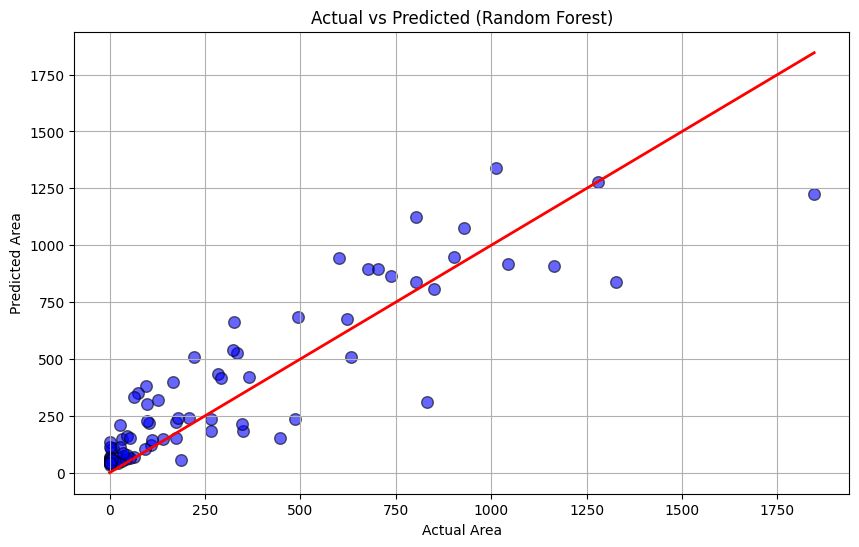

In [36]:
# Visualize the actual vs. predicted data points
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.6, s=70)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)

plt.xlabel('Actual Area')
plt.ylabel('Predicted Area')
plt.title('Actual vs Predicted (Random Forest)')
plt.grid(True)
plt.show()

In [37]:
X, y = prepare_data(data['Area'], n_steps)
data_pred = best_rfr_model.predict(X)

In [38]:
data_pred

array([1386.11512244,  972.82429071,  774.88472493, ..., 1278.00756973,
       1341.32813379, 1123.07712953])

In [39]:
data_scaled=data[96:]
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(data_scaled)))

In [40]:
DF = pd.DataFrame()
DF['original'] = data_scaled
DF = DF.set_index(date)

In [41]:
DF1=pd.DataFrame()
DF1['predicted']=data_pred
DF1 = DF1.set_index(date)

In [42]:
df = pd.concat([DF, DF1], ignore_index=False, axis=1)
df.head()

,original,predicted
1882-05,1519.6,1386.115122
1882-06,557.8,972.824291
1882-07,461.5,774.884725
1882-08,607.6,700.180722
1882-09,1026.9,919.340845


<Figure size 3000x1800 with 0 Axes>

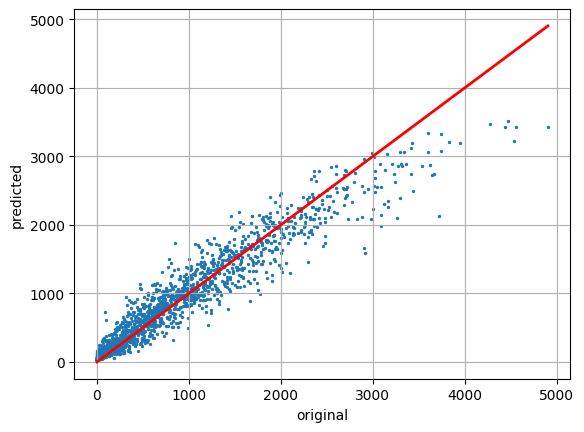

In [43]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6), dpi=300)
df.plot(kind='scatter', x='original', y='predicted', s=2, alpha=1)
plt.plot([min(data_scaled['Area']), max(data_scaled['Area'])], [min(data_scaled['Area']), max(data_scaled['Area'])], color='red', linewidth=2)
plt.grid(True)
plt.gca().spines[['top', 'right',]].set_visible(True)
plt.show()

Text(0, 0.5, 'VALUE')

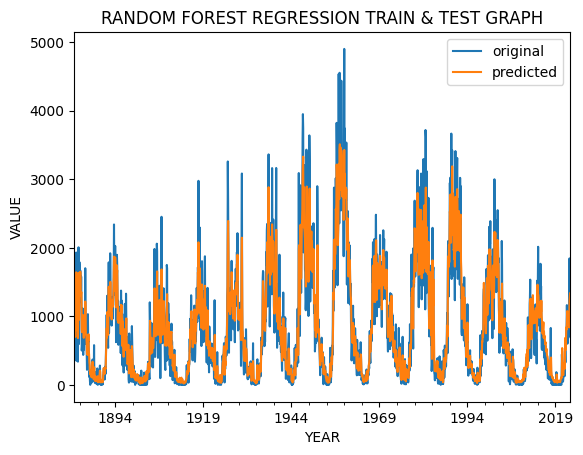

In [44]:
df.plot()
plt.title('RANDOM FOREST REGRESSION TRAIN & TEST GRAPH',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
#plt.savefig('RF_train_test.png')

# Future Predictions of 10years(2023-2033)

In [45]:
len(y_test),len(y_pred)

(83, 83)

In [46]:
# Assuming 'data' is a list or a NumPy array that you want to convert into 't_df'
t_df = np.array(data)
fut_inp = t_df[1692:].reshape(1,-1)
# Directly convert 't_df' to a list and extract the required portion
tmp_inp = fut_inp.flatten().tolist()

In [48]:
tmp_inp

[625.0,
 840.5,
 514.8,
 715.9,
 593.6,
 464.7,
 397.1,
 569.0,
 366.7,
 381.9,
 296.3,
 566.5,
 502.6,
 220.7,
 334.6,
 282.7,
 365.6,
 291.7,
 96.1,
 98.0,
 175.2,
 103.0,
 97.5,
 348.6,
 75.5,
 138.6,
 265.3,
 346.4,
 830.7,
 167.1,
 26.6,
 31.2,
 8.6,
 109.5,
 2.7,
 28.0,
 33.9,
 63.0,
 0.5,
 21.2,
 1.9,
 7.7,
 11.2,
 4.5,
 33.4,
 0.0,
 53.7,
 186.7,
 173.9,
 1.9,
 0.9,
 0.5,
 1.4,
 0.0,
 0.9,
 2.3,
 22.1,
 1.4,
 1.4,
 7.5,
 1.8,
 42.9,
 44.5,
 36.1,
 0.9,
 91.7,
 446.4,
 324.3,
 63.7,
 45.7,
 52.4,
 110.8,
 209.1,
 178.3,
 264.6,
 126.9,
 485.3,
 494.7,
 326.7,
 632.7,
 621.0,
 803.5,
 849.5,
 1163.9,
 929.9,
 602.0,
 1043.7,
 677.0,
 902.5,
 737.9,
 702.6,
 1326.4,
 1846.2,
 1278.5,
 1013.2,
 802.0]

In [47]:
fut_inp.shape

(1, 96)

In [49]:
lst_output = []
n_steps = 96
future_periods = 120
i = 0
while(i < future_periods):

    if(len(tmp_inp) > n_steps):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp = fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape(( 1,n_steps))
        yhat = best_rfr_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        fut_inp = fut_inp.reshape((1, n_steps))
        yhat = best_rfr_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

lst_output

[[1032.5396732833392],
 [1062.4456404106038],
 [1113.1280135237253],
 [1235.6130950962688],
 [1343.8979246177958],
 [1611.8914866142306],
 [1515.780427163189],
 [1532.5717224444777],
 [1651.3255752723287],
 [1615.8379970224996],
 [1638.409132033635],
 [1608.5643607333948],
 [1535.6527163428807],
 [1667.442142073911],
 [1526.1033762012748],
 [1551.3293350488366],
 [1562.2149356232096],
 [1527.4149799119448],
 [1332.8528492988999],
 [1442.8246372486904],
 [1311.203017863491],
 [1367.2185443591213],
 [1336.0609036413257],
 [1316.5366132430383],
 [1380.6426368671887],
 [1352.9297162929452],
 [1230.191563441087],
 [1084.4891376756484],
 [1053.755608426708],
 [1064.9384814754128],
 [1012.4592668499604],
 [1029.5099928090253],
 [974.5930674446612],
 [961.8515635352048],
 [952.5139552031445],
 [956.3005158242368],
 [966.6317211990178],
 [914.7775262078997],
 [879.3055239376047],
 [781.6475800137216],
 [765.6945177793783],
 [699.9982630997554],
 [694.3804598901585],
 [685.3201769732799],
 [626.

In [50]:
data_pred = data_pred.reshape(-1,1)

In [51]:
data_pred.shape

(1692, 1)

In [52]:
data_pred = np.vstack((data_pred, np.array(lst_output)))

In [53]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(data_scaled)+120))

In [54]:
DF = pd.DataFrame()
DF['original'] = data_scaled
DF = DF.set_index(date[:-120])

In [55]:
DF1 = pd.DataFrame()
DF1['predicted'] = data_pred.flatten()
DF1 = DF1.set_index(date)

In [56]:
df = pd.concat([DF, DF1], ignore_index=False, axis=1)
df

,original,predicted
1882-05,1519.6,1386.115122
1882-06,557.8,972.824291
1882-07,461.5,774.884725
1882-08,607.6,700.180722
1882-09,1026.9,919.340845
...,...,...
2032-12,NaN,30.403832
2033-01,NaN,37.078059
2033-02,NaN,42.039814
2033-03,NaN,43.563252


Text(0, 0.5, 'VALUE')

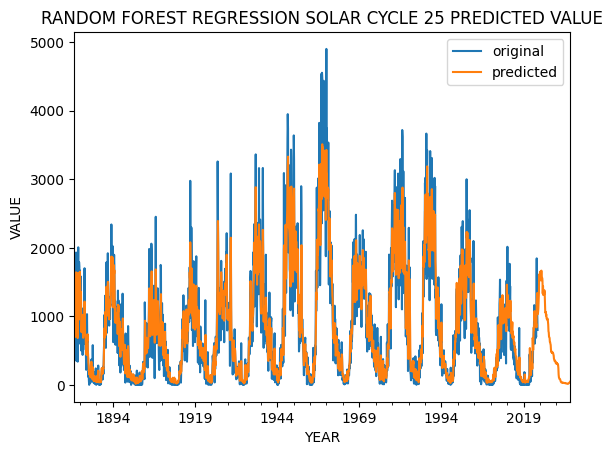

In [57]:
df.plot()
plt.title('RANDOM FOREST REGRESSION SOLAR CYCLE 25 PREDICTED VALUE',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
#plt.savefig('RF_predict.png')

In [58]:
print("Largest element is:", max(lst_output))

Largest element is: [1667.442142073911]


In [59]:
# Assuming lst_output is a non-empty list of numerical values
max_index = max(enumerate(lst_output), key=lambda x: x[1])[0]
max_index

13

In [60]:
max_index = np.argmax(lst_output)
max_index

13

In [61]:
new_date = np.datetime64('2023-05') + np.timedelta64(max_index, 'M')
print('Peak month is : '+str(new_date))

Peak month is : 2024-06


In [62]:
df.query('predicted <= 0')

,original,predicted


# **26th Solar Cycle Prediction**

# Dataset(with 10yrs Prediction)

In [63]:
n_data = np.append(np.array(data['Area']), np.array(lst_output))

In [64]:
DATE = pd.Series(pd.period_range("1874-05-01", freq="M", periods=len(n_data)))

In [65]:
data = pd.DataFrame()
data['Area'] = n_data
data = data.set_index(DATE)

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1908 entries, 1874-05 to 2033-04
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    1908 non-null   float64
dtypes: float64(1)
memory usage: 29.8 KB


# EDA

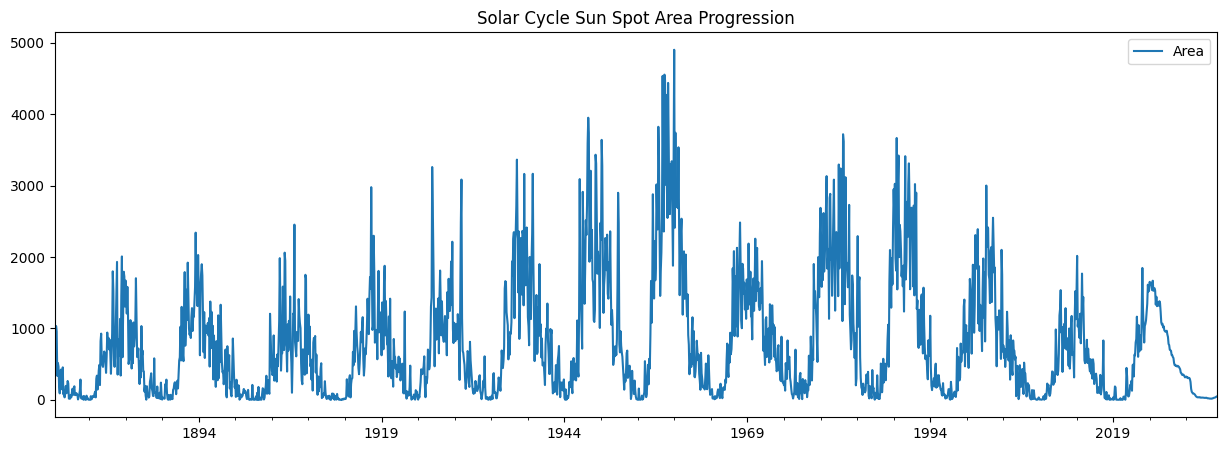

In [67]:
data.plot(style='-',
        figsize=(15, 5),
        title='Solar Cycle Sun Spot Area Progression')
plt.show()

# Train-Test Split

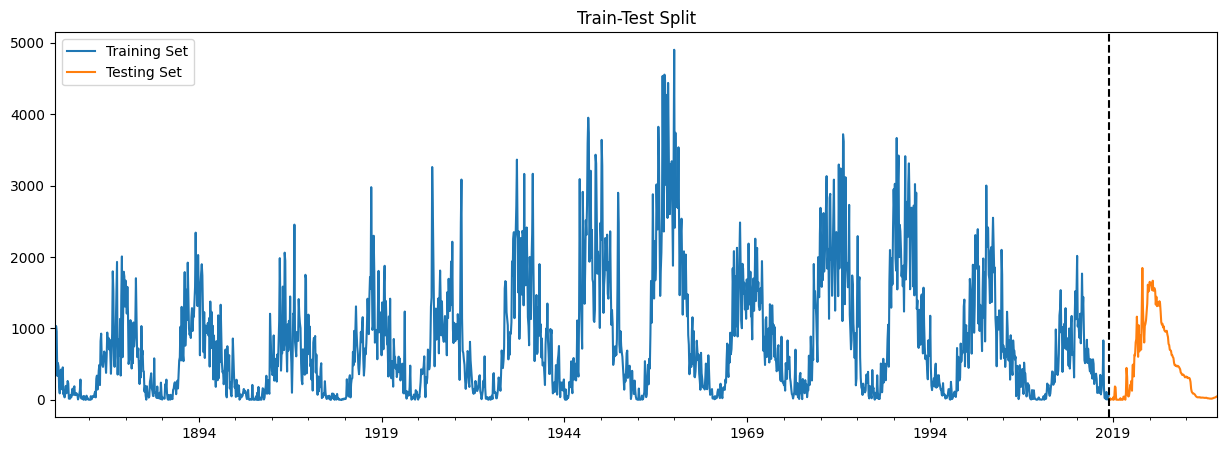

In [68]:
train_data = data.loc[data.index < '2018-07-01']
test_data = data.loc[data.index >= '2018-07-01']
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label='Training Set', title='Train-Test Split')
test_data.plot(ax=ax, label='Testing Set')
ax.axvline('2018-07-01', color='black', ls='--')
ax.legend(['Training Set', 'Testing Set'])
plt.show()

In [69]:
train_data

,Area
1874-05,365.1
1874-06,415.2
1874-07,1033.5
1874-08,954.1
1874-09,335.3
...,...
2018-02,109.5
2018-03,2.7
2018-04,28.0
2018-05,33.9


In [70]:
n_steps=96
X_train, y_train = prepare_data(train_data['Area'], n_steps)
X_test, y_test = prepare_data(test_data['Area'], n_steps)

In [71]:
X_train.shape

(1634, 96)

In [72]:
X_test.shape

(82, 96)

In [73]:
X_train

array([[ 365.1,  415.2, 1033.5, ...,  673.1,  928.9, 1799.1],
       [ 415.2, 1033.5,  954.1, ...,  928.9, 1799.1, 1519.6],
       [1033.5,  954.1,  335.3, ..., 1799.1, 1519.6,  557.8],
       ...,
       [  85.4,   54.9,   85.9, ...,    8.6,  109.5,    2.7],
       [  54.9,   85.9,  182.5, ...,  109.5,    2.7,   28. ],
       [  85.9,  182.5,  234.4, ...,    2.7,   28. ,   33.9]])

In [74]:
ts_cv2 = TimeSeriesSplit(
    n_splits=9,
    gap=5,
    max_train_size=1900,
    test_size=179,
)

# 26th Cycle Prediction Model

In [75]:
def objective(trial):
      bootstrap = trial.suggest_categorical("bootstrap", [True, False])
      n_estimators = trial.suggest_int("n_estimators", 50, 500)
      min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5)
      max_depth = trial.suggest_int("max_depth", 3, 40)
      min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
      min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
      random_state = trial.suggest_int("random_state", 0, 150)
      warm_start = trial.suggest_categorical("warm_start", [True, False])

      rfr_model = RandomForestRegressor(criterion='squared_error',
                                  bootstrap = bootstrap,
                                  n_estimators = n_estimators,
                                  min_weight_fraction_leaf = min_weight_fraction_leaf,
                                  max_depth = max_depth,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  random_state = random_state,
                                  warm_start = warm_start)  # Define the model.

      score = sklearn.model_selection.cross_val_score(rfr_model, X_train, y_train, n_jobs=-1, cv= ts_cv2, scoring = 'neg_mean_squared_error').mean()  # Train and evaluate the model.

      return score

In [76]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2024-06-08 05:27:56,254] A new study created in memory with name: no-name-f948d0dd-3d72-4e94-bb48-17bc0ea02715
[I 2024-06-08 05:28:12,226] Trial 0 finished with value: -423667.0894883849 and parameters: {'bootstrap': True, 'n_estimators': 225, 'min_weight_fraction_leaf': 0.3394531114780685, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'random_state': 42, 'warm_start': True}. Best is trial 0 with value: -423667.0894883849.
[I 2024-06-08 05:28:24,692] Trial 1 finished with value: -351174.2685497368 and parameters: {'bootstrap': True, 'n_estimators': 161, 'min_weight_fraction_leaf': 0.20063939105514583, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1, 'random_state': 23, 'warm_start': True}. Best is trial 1 with value: -351174.2685497368.
[I 2024-06-08 05:29:38,642] Trial 2 finished with value: -372324.5178557908 and parameters: {'bootstrap': False, 'n_estimators': 255, 'min_weight_fraction_leaf': 0.031008541647257637, 'max_depth': 25, 'min_samples_spl

In [77]:
best_params = study.best_params
best_params

{'bootstrap': True,
 'n_estimators': 257,
 'min_weight_fraction_leaf': 0.00042290043443914127,
 'max_depth': 33,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'random_state': 116,
 'warm_start': False}

In [78]:
optuna.visualization.plot_slice(study)

In [79]:
optuna.visualization.plot_optimization_history(study)

In [80]:
optuna.visualization.plot_param_importances(study)

In [81]:
optuna.visualization.plot_parallel_coordinate(study)

In [82]:
best_bootstrap = best_params['bootstrap']
best_n_estimators = best_params['n_estimators']
best_min_weight_fraction_leaf = best_params['min_weight_fraction_leaf']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']
best_random_state = best_params['random_state']
best_warm_start = best_params['warm_start']

In [83]:
best_rfr_model = RandomForestRegressor(criterion='squared_error',
                                  bootstrap = best_bootstrap,
                                  n_estimators = best_n_estimators,
                                  min_weight_fraction_leaf = best_min_weight_fraction_leaf,
                                  max_depth = best_max_depth,
                                  min_samples_split = best_min_samples_split,
                                  min_samples_leaf = best_min_samples_leaf,
                                  random_state = best_random_state,
                                  warm_start = best_warm_start)

best_rfr_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=33, min_samples_leaf=5,
                      min_weight_fraction_leaf=0.00042290043443914127,
                      n_estimators=257, random_state=116)

In [84]:
y_pred = best_rfr_model.predict(X_test)
y_pred

array([844.10963509, 766.98128949, 760.79036467, 691.23187808,
       671.00589505, 640.03760468, 599.07902881, 620.75996318,
       600.67729894, 586.16771865, 475.80575562, 466.00037285,
       456.58306185, 471.22048376, 482.01396808, 446.59448887,
       453.26646501, 448.43021227, 430.30260019, 421.18842541,
       409.85144717, 385.40184921, 357.84554989, 355.89750338,
       350.20907155, 348.17193151, 347.73522203, 331.70445368,
       319.1180235 , 310.75250651, 323.43024852, 305.09410203,
       313.9276667 , 299.16963944, 309.4313639 , 305.924088  ,
       292.91514789, 230.34921449, 151.71054263, 103.73209846,
        92.5182253 ,  94.09299317,  87.41802543,  86.71661883,
        72.12289634,  55.02271343,  44.46201263,  39.50400383,
        36.58438985,  35.67332728,  34.82657979,  30.87931095,
        31.22376759,  30.97755157,  20.34019911,  21.3202472 ,
        19.06546409,  18.83446331,  19.71883035,  21.60439681,
        17.73539163,  20.11720982,  20.81791567,  20.70

In [85]:
RMSE = np.sqrt(mean_squared_error(y_pred,y_test))
RMSE

12.868768291648307

In [86]:
R2_score=r2_score(y_pred,y_test)
R2_score

0.9969175702110683

In [87]:
MAPE = mean_absolute_percentage_error(y_pred, y_test)
MAPE

0.10686798786208376

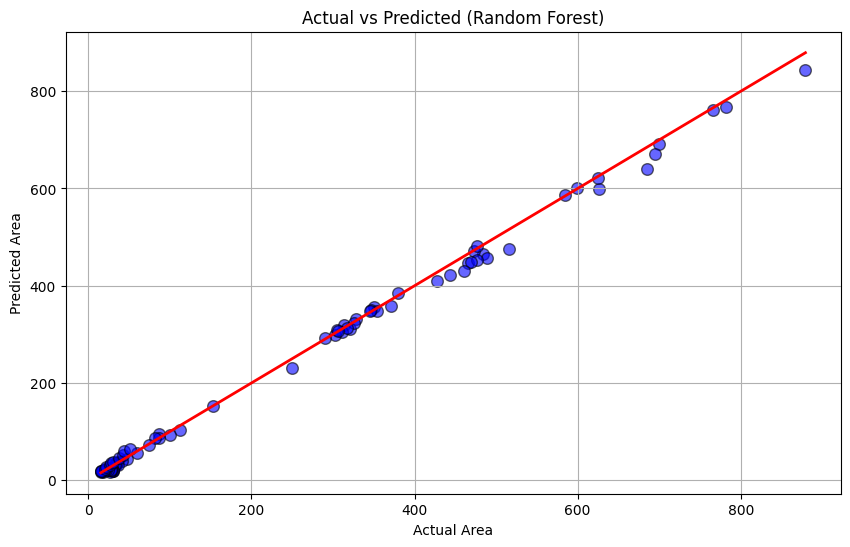

In [88]:
# Visualize the actual vs. predicted data points
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.6, s=70)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)

plt.xlabel('Actual Area')
plt.ylabel('Predicted Area')
plt.title('Actual vs Predicted (Random Forest)')
plt.grid(True)
plt.show()

In [89]:
X, y = prepare_data(data['Area'], n_steps)
data_pred = best_rfr_model.predict(X)

In [90]:
data_pred

array([1381.75637612,  915.4000657 ,  750.99452919, ...,   51.25079662,
         59.24529339,   63.28612032])

In [91]:
data_scaled=data[96:]
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(data_scaled)))

In [92]:
DF = pd.DataFrame()
DF['original'] = data_scaled
DF = DF.set_index(date)

In [93]:
DF1=pd.DataFrame()
DF1['predicted']=data_pred
DF1 = DF1.set_index(date)

In [94]:
df = pd.concat([DF, DF1], ignore_index=False, axis=1)
df.head()

,original,predicted
1882-05,1519.6,1381.756376
1882-06,557.8,915.400066
1882-07,461.5,750.994529
1882-08,607.6,707.957267
1882-09,1026.9,924.032180


<Figure size 3000x1800 with 0 Axes>

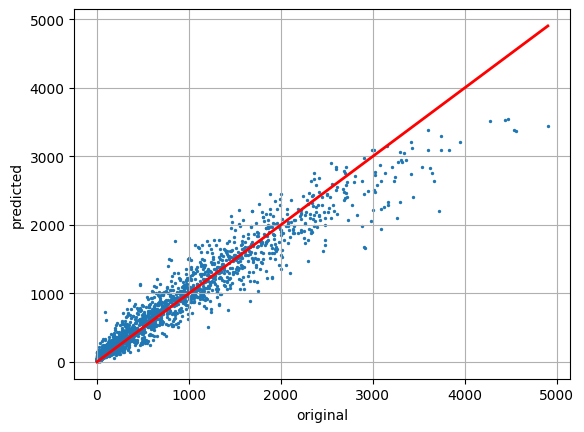

In [95]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6), dpi=300)
df.plot(kind='scatter', x='original', y='predicted', s=2, alpha=1)
plt.plot([min(data_scaled['Area']), max(data_scaled['Area'])], [min(data_scaled['Area']), max(data_scaled['Area'])], color='red', linewidth=2)
plt.grid(True)
plt.gca().spines[['top', 'right',]].set_visible(True)
plt.show()

Text(0, 0.5, 'VALUE')

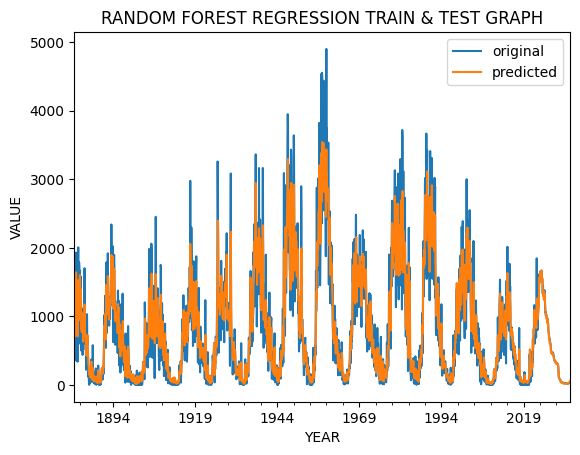

In [96]:
df.plot()
plt.title('RANDOM FOREST REGRESSION TRAIN & TEST GRAPH',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
#plt.savefig('RF_train_test.png')

# Future Predictions of 10years(2033-2043)

In [97]:
len(y_test),len(y_pred)

(82, 82)

In [98]:
# Assuming 'data' is a list or a NumPy array that you want to convert into 't_df'
t_df = np.array(data)
fut_inp = t_df[1812:].reshape(1,-1)
# Directly convert 't_df' to a list and extract the required portion
tmp_inp = fut_inp.flatten().tolist()

In [99]:
tmp_inp

[1380.6426368671887,
 1352.9297162929452,
 1230.191563441087,
 1084.4891376756484,
 1053.755608426708,
 1064.9384814754128,
 1012.4592668499604,
 1029.5099928090253,
 974.5930674446612,
 961.8515635352048,
 952.5139552031445,
 956.3005158242368,
 966.6317211990178,
 914.7775262078997,
 879.3055239376047,
 781.6475800137216,
 765.6945177793783,
 699.9982630997554,
 694.3804598901585,
 685.3201769732799,
 626.6185816819794,
 624.5631921724347,
 598.8087086616373,
 584.3606623904608,
 515.6398276811839,
 483.86524947411385,
 488.58670242938393,
 472.74246717492434,
 476.0512433707828,
 465.18491903497716,
 476.38756338569806,
 468.9919990067556,
 460.6282835786506,
 443.93065621800514,
 426.9781782098842,
 380.06684576337574,
 371.2109223574613,
 350.78346950422764,
 346.56300353546646,
 353.5553145618811,
 344.97546147592607,
 327.6458241266157,
 313.58059339939945,
 320.67280920085113,
 325.47969100876,
 311.54622773340526,
 317.3948863997575,
 302.26889958636946,
 305.0091483620938,
 3

In [100]:
fut_inp.shape

(1, 96)

In [101]:
lst_output = []
n_steps = 96
future_periods = 120
i = 0
while(i < future_periods):

    if(len(tmp_inp) > n_steps):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp = fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape(( 1,n_steps))
        yhat = best_rfr_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        fut_inp = fut_inp.reshape((1, n_steps))
        yhat = best_rfr_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

lst_output

[[67.07170133718601],
 [102.49371072361856],
 [156.31395515453997],
 [195.61747364366144],
 [208.0669924068913],
 [218.39038000036587],
 [238.85180665425426],
 [257.9142652884572],
 [297.1505087931151],
 [412.1266598551505],
 [434.63699771916976],
 [476.51011718618145],
 [628.7643445589385],
 [671.7466800931848],
 [724.163495293179],
 [740.5846123431826],
 [750.4319872400561],
 [753.4396044986323],
 [761.3161726488892],
 [783.2822474082598],
 [800.6180282728266],
 [836.2050214726163],
 [839.1609178653048],
 [846.7646792472322],
 [850.7437164007174],
 [855.9329189535243],
 [875.6600102502391],
 [869.5245227229049],
 [895.5841053759527],
 [895.9706143742532],
 [915.1950354881905],
 [925.1554983804076],
 [930.3196486522319],
 [924.8422641992157],
 [921.0637346505113],
 [933.1456522897242],
 [926.4708590868468],
 [938.543819203864],
 [965.8397846457173],
 [965.3151219773661],
 [979.1680681555699],
 [983.5579278387519],
 [991.7357597679555],
 [995.1763890148878],
 [976.1111359033217],
 [956

In [102]:
data_pred = data_pred.reshape(-1,1)
data_pred.shape

(1812, 1)

In [103]:
data_pred = np.vstack((data_pred, np.array(lst_output)))

In [104]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(data_scaled)+120))

In [105]:
DF = pd.DataFrame()
DF['original'] = data_scaled
DF = DF.set_index(date[:-120])

In [106]:
DF1 = pd.DataFrame()
DF1['predicted'] = data_pred.flatten()
DF1 = DF1.set_index(date)

In [107]:
df = pd.concat([DF, DF1], ignore_index=False, axis=1)
df

,original,predicted
1882-05,1519.6,1381.756376
1882-06,557.8,915.400066
1882-07,461.5,750.994529
1882-08,607.6,707.957267
1882-09,1026.9,924.032180
...,...,...
2042-12,NaN,416.115538
2043-01,NaN,420.827596
2043-02,NaN,421.143779
2043-03,NaN,424.564411


Text(0, 0.5, 'VALUE')

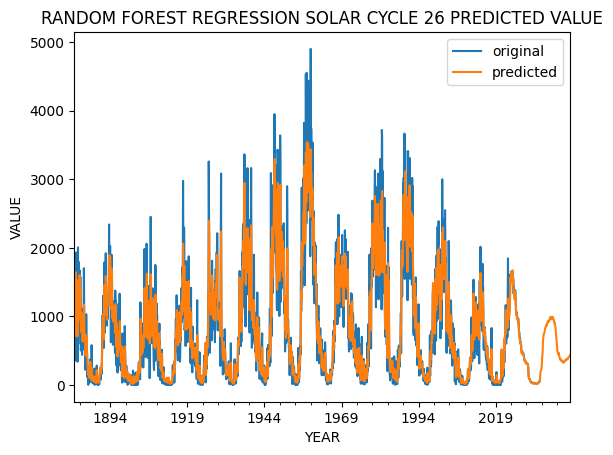

In [112]:
df.plot()
plt.title('RANDOM FOREST REGRESSION SOLAR CYCLE 26 PREDICTED VALUE',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
#plt.savefig('RF_predict.png')

In [109]:
print("Largest element is:", max(lst_output))

Largest element is: [995.1763890148878]


In [110]:
# Assuming lst_output is a non-empty list of numerical values
max_index = max(enumerate(lst_output), key=lambda x: x[1])[0]
max_index

43

In [111]:
max_index = np.argmax(lst_output)
max_index

43

In [113]:
new_date = np.datetime64('2033-05') + np.timedelta64(max_index, 'M')
print('Peak month is : '+str(new_date))

Peak month is : 2036-12


In [114]:
df.query('predicted <= 0')

,original,predicted
